In [3]:
import warnings
warnings.simplefilter('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
df = pd.read_csv('../datasets/SEHIR/processed_dataset.csv')
df

,Course Code,Course Title,Student Number,Department Code,Course Level,Letter Grade,Status,GPA,Standing,Completed Credits,Completed ECTS,GPA Student - Subject,Avg. Grade - Taken,Avg. Grade - Students_Subject,Semester,Theoritical,Practical,Course Credit,ECTS,Course Year
0,UNI 111,Critical Reading & Writing in Turkish I,240,SOC,Undergraduate,F,Unsuccessful,2.62,Freshman,18,30,2.616667,2.113636,2.703226,2011 - Fall,3,0,3,5,1
1,UNI 107,World Civilizations& Global Encounters I,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,2.986364,2.703226,2011 - Fall,3,0,3,5,1
2,UNI 105,Understanding Society and Culture I,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,3.211538,2.703226,2011 - Fall,3,0,3,5,1
3,UNI 103,Understanding Science and Technology,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,3.176000,2.703226,2011 - Fall,3,0,3,5,1
4,UNI 105,Understanding Society and Culture I,240,SOC,Undergraduate,A,Successful,2.62,Freshman,18,30,2.616667,3.211538,2.703226,2011 - Fall,3,0,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48736,MGT 531,Stratejik Yönetim,1102,MBA/NT,Graduate,A-,Successful,3.80,Freshman,24,40,3.800000,3.391758,3.049526,2014 - Spring,3,0,3,5,5
48737,MGT 585,Operasyon Yönetimi,1102,MBA/NT,Graduate,A,Successful,3.80,Freshman,24,40,3.800000,3.440476,3.049526,2014 - Spring,3,0,3,5,5
48738,MGT 552,İnsan Kaynakları Yönetimi,1102,MBA/NT,Graduate,A,Successful,3.80,Freshman,24,40,3.800000,3.393077,3.049526,2014 - Spring,3,0,3,5,5
48739,MGT 574,Makroekonomik Göster. ve Pol. Anal.,1984,MBA/NT,Graduate,A-,Successful,3.20,Sophomore,24,40,3.200000,3.570769,3.049526,2014 - Spring,3,0,3,5,5


In [5]:
df_raw = df.copy()

In [6]:
df.drop([df.columns[0], df.columns[1], df.columns[2]], inplace=True, axis=1)   # dropping course details

In [7]:
df = pd.concat([df, pd.get_dummies(df['Course Year'], prefix='Course Year'), pd.get_dummies(df['Department Code'], prefix='Department Code'), pd.get_dummies(df['Course Level'], prefix='Course Level'), pd.get_dummies(df['Standing'], prefix='Standing'), pd.get_dummies(df['Status'], prefix='Status')], axis=1)
df.drop(['Course Year', 'Department Code', 'Course Level', 'Status', 'Standing'], axis=1, inplace=True)

In [8]:
def plot_target_distribution():
    fig, ax = plt.subplots(figsize=(7.59, 2.277), edgecolor='grey')
    target_values = df[['Letter Grade', 'Semester']].groupby('Letter Grade', as_index=False).count()
    x = target_values['Letter Grade']
    y = target_values['Semester']
    
    for i, j in zip(x, y):
        ax.bar(i, j, hatch='////', color='white')
    
    for i, v in enumerate(y):
        plt.text(i-0.45, v+180, str(v), fontfamily='serif', fontweight='bold', fontsize=9.5)
    
    plt.ylabel('Count', fontsize=11, fontfamily='serif')
    plt.xlabel('Letter Grade', fontsize=11, fontfamily='serif')
    plt.xticks(fontfamily='serif', fontsize=11)
    plt.yticks(range(0,7501,1500), fontfamily='serif', fontsize=11)
    axes = plt.gca()
    axes.yaxis.grid()
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False) 
    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.tick_params(axis = "y", which = "both", left = False, right = False)        
    plt.savefig('target_dist.eps', bbox_inches='tight', dpi=1200)

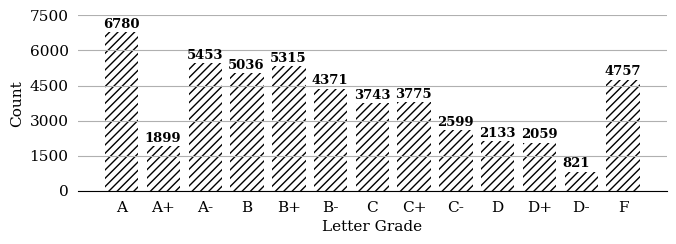

In [9]:
plot_target_distribution()

In [10]:
columns = df.columns

In [11]:
le = LabelEncoder()
le.fit(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F'])

LabelEncoder()

In [12]:
def standardize(X_train, X_test):
    X_train_cols = X_train.columns
    X_test_cols = X_test.columns
    sc = StandardScaler()
    fitted_sc = sc.fit(X_train)
    X_train_std = pd.DataFrame(fitted_sc.transform(X_train), columns=X_train_cols)
    X_test_std = pd.DataFrame(fitted_sc.transform(X_test), columns=X_test_cols)
    return X_train_std, X_test_std

In [13]:
def get_train_data(df, train_sem, columns):
    dataFrame = pd.DataFrame(columns=columns)
    for sem in train_sem:
        dataFrame = pd.concat([dataFrame, df[df.iloc[:, 7] == sem]], ignore_index=True)
    
    X_train = dataFrame.drop('Semester', axis=1)
    y_train = le.transform(X_train.pop('Letter Grade'))
    return X_train, y_train

In [ ]:
def get_error_score(df, columns, model):
    error_scores = {}
    sorted_semesters = sorted(set(df.iloc[:, 7]))
    for sem_idx in range(1, len(sorted_semesters)):
        training_sem = sorted_semesters[:sem_idx]
        test_sem = sorted_semesters[sem_idx]
        X_train, y_train = get_train_data(df, training_sem, columns)
        X_test = df[df.iloc[:, 7] == test_sem]
        X_test.drop('Semester', axis=1, inplace=True)
        y_test = le.transform(X_test.pop('Letter Grade'))
        
        X_train, X_test = standardize(X_train, X_test)
        model.fit(X_train, y_train)
        
        y_pred_test = model.predict(X_test)
        rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
        mae_test = round(mean_absolute_error(y_test, y_pred_test), 3)
        
        y_pred_train = model.predict(X_train)
        rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3)
        mae_train = round(mean_absolute_error(y_train, y_pred_train),3)
        
        error_scores.setdefault(sem_idx, {})
        error_scores[sem_idx]['rmse'] = [rmse_train, rmse_test]
        error_scores[sem_idx]['mae'] = [mae_train, mae_test]        
        
    return error_scores

In [15]:
def plot_error_score(scores, model_name):
    errors = {}
    for k in sorted(scores):
        for metric in scores[k]:
            errors.setdefault(metric + ' train', [])
            errors[metric + ' train'].append(scores[k][metric][0])
            errors.setdefault(metric + ' test', [])
            errors[metric + ' test'].append(scores[k][metric][1])
    
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(x - 3*0.15/2, errors['rmse test'], 0.15, label='RMSE - test')
    rects2 = ax.bar(x - 0.15/2, errors['rmse train'], 0.15, label='RMSE - train')
    rects4 = ax.bar(x + 0.15/2, errors['mae train'], 0.15, label='MAE - train')
    rects3 = ax.bar(x + 3*0.15/2, errors['mae test'], 0.15, label='MAE - test')
    
    for i, v in enumerate(errors['rmse test']):
        ax.text(i-0.28, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['rmse train']):
        ax.text(i-0.12, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['mae train']):
        ax.text(i+0.025, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    for i, v in enumerate(errors['mae test']):
        ax.text(i+0.18, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters - ({})'.format(model_name), fontsize=22, fontfamily='serif')
    ax.set_ylim(top=list(ax.get_ylim())[1]+0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels(ax.get_yticks(), fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 17, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=4)

In [16]:
with open('../hyperparameters/tuned_hyperparams (student based).json') as fr:
    tuned_hyperparams = json.load(fr)

In [17]:
model_results = {}

# Support Vector Machines:
### Support Vector Regressor:
* Observations: The model does not overfit, but there is high bias.

In [ ]:
hps = tuned_hyperparams['SVR']
scores = get_error_score(df, columns, SVR(C=hps['C'], kernel=hps['kernel'], epsilon=hps['epsilon']))
model_results['SVR'] = scores
plot_error_score(scores, 'Support Vector Regressor')

# Linear Models:
### BayesianRidge:
* Observations: The model does not overfit, but there is high bias.

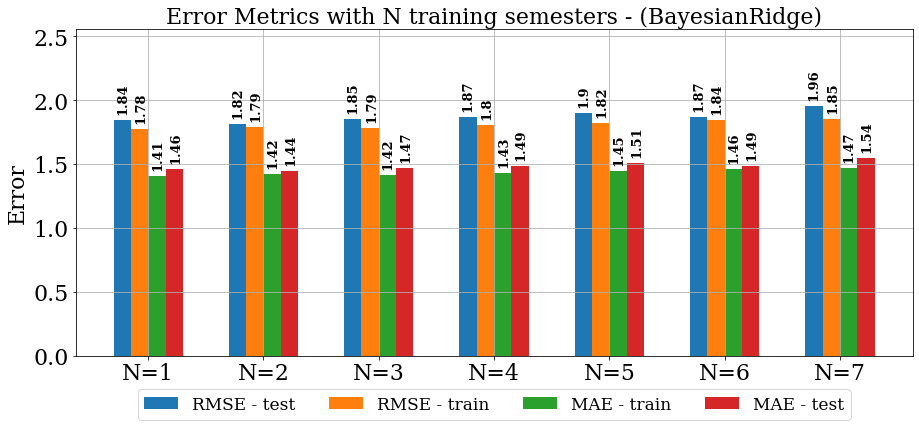

In [ ]:
hps = tuned_hyperparams['BayesianRidge']
scores = get_error_score(df, columns, BayesianRidge(lambda_1=hps['lambda_1'], lambda_2=hps['lambda_2'],
                                                    alpha_1=hps['alpha_1'], alpha_2=hps['alpha_2']))
model_results['BayesianRidge'] = scores
plot_error_score(scores, 'BayesianRidge')

### Lasso:
* Observations: The model does not overfit but there is high bias.

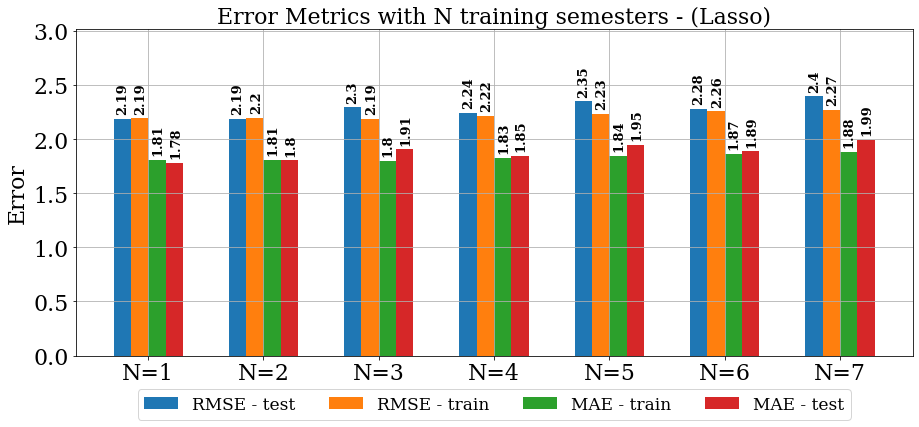

In [ ]:
hps = tuned_hyperparams['Lasso']
scores = get_error_score(df, columns, Lasso(alpha=hps['alpha']))
model_results['Lasso'] = scores
plot_error_score(scores, 'Lasso')

### Ridge:
* Observations: The model does not overfit but there is high bias.

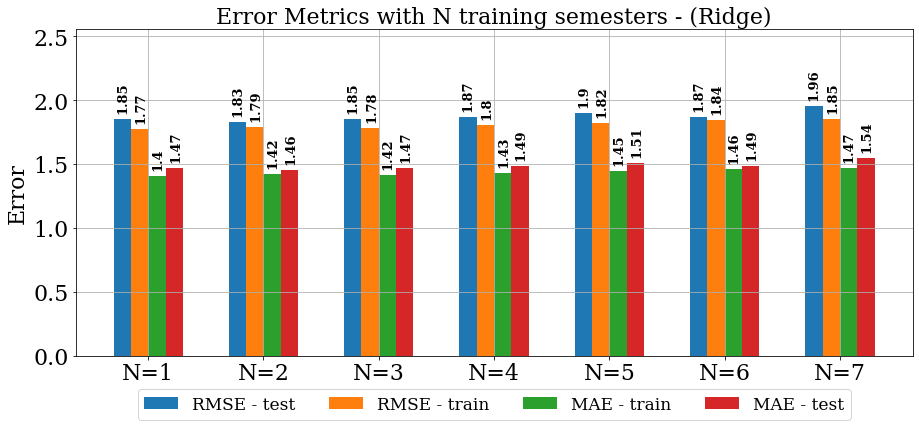

In [ ]:
hps = tuned_hyperparams['Ridge']
scores = get_error_score(df, columns, Ridge(alpha=hps['alpha']))
model_results['Ridge'] = scores
plot_error_score(scores, 'Ridge')

# Ensemble Models:
### BaggingRegressor:
* Observations: The model has both, high bias and variance.

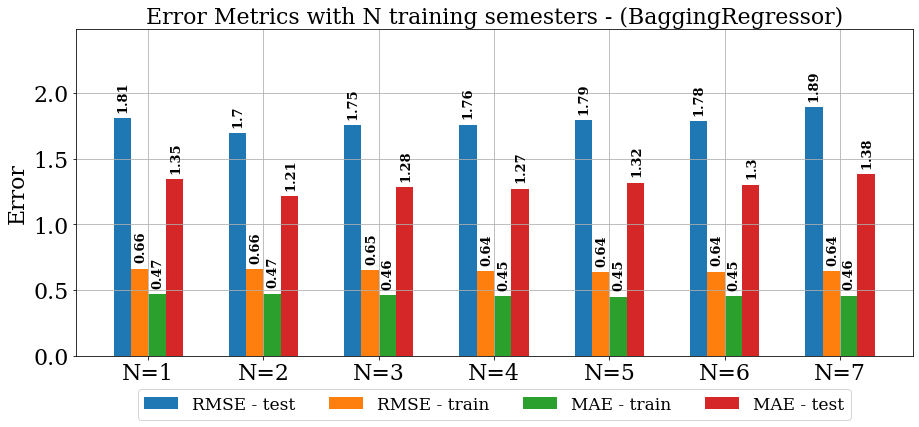

In [ ]:
hps = tuned_hyperparams['BaggingRegressor']
scores = get_error_score(df, columns, BaggingRegressor(n_estimators=hps['n_estimators']))
model_results['Bagging'] = scores
plot_error_score(scores, 'BaggingRegressor')

### AdaBoostRegressor:
* Observations: The model does not overfit but there is high bias.

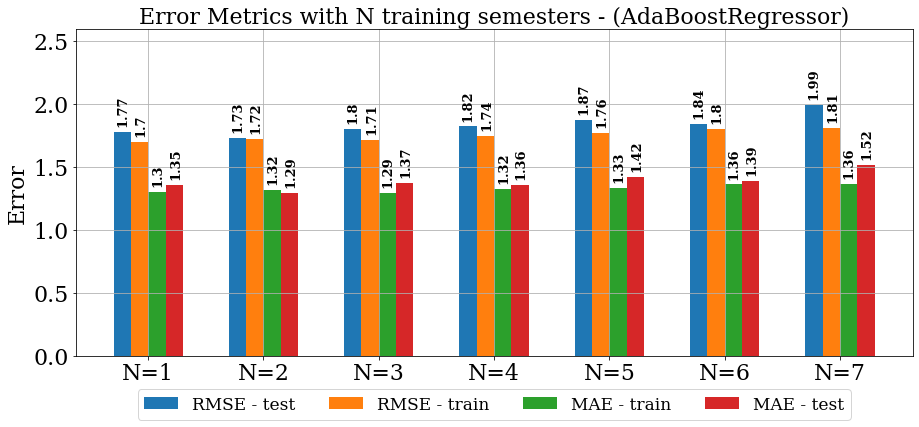

In [ ]:
hps = tuned_hyperparams['AdaBoostRegressor']
scores = get_error_score(df, columns, AdaBoostRegressor(n_estimators=hps['n_estimators'], learning_rate=hps['learning_rate']))
model_results['AdaBoostRegressor'] = scores
plot_error_score(scores, 'AdaBoostRegressor')

### RandomForestRegressor:
* Observations: The model has both, high bias and variance.

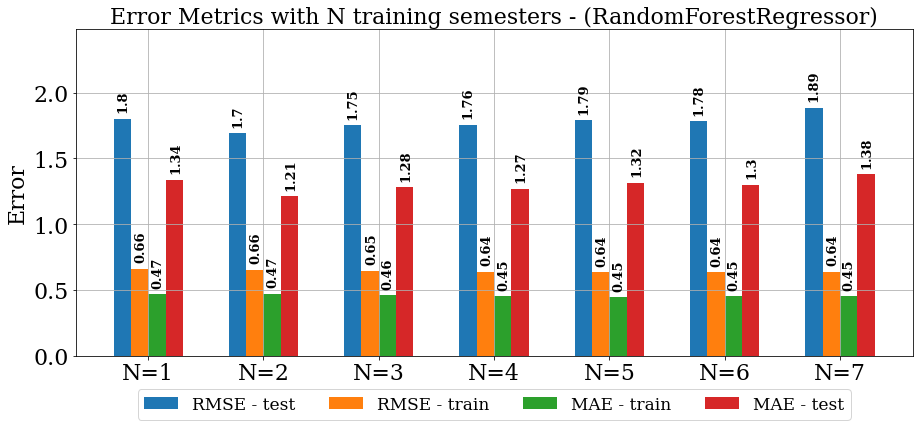

In [ ]:
hps = tuned_hyperparams['RandomForestRegressor']
scores = get_error_score(df, columns, RandomForestRegressor(n_estimators=hps['n_estimators']))
model_results['RandomForestRegressor'] = scores
plot_error_score(scores, 'RandomForestRegressor')

### GradientBoostingRegressor:
* Observations: The model does not overfit but there is high bias.

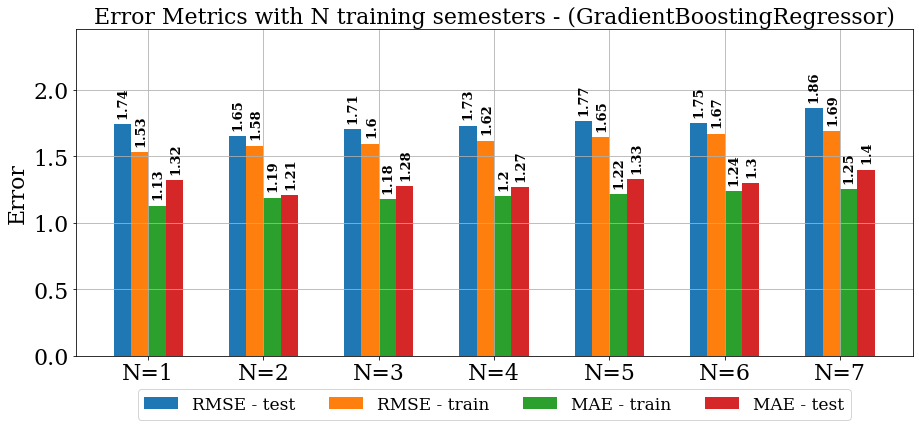

In [ ]:
hps = tuned_hyperparams['GradientBoostingRegressor']
scores = get_error_score(df, columns, GradientBoostingRegressor(learning_rate=hps['learning_rate'], loss=hps['loss'],
                                                                n_estimators=hps['n_estimators'], max_depth=hps['max_depth']))
model_results['GradientBoostingRegressor'] = scores
plot_error_score(scores, 'GradientBoostingRegressor')

In [ ]:
with open('baseline_regression_results.json', 'w') as fw:
    json.dump(model_results, fw)

# Yeni: Neural Network Architechture (MLP Regressor)

MLPRegressor çalıştırılıyor...
MLPRegressor sonuçları dosyaya eklendi! ✅


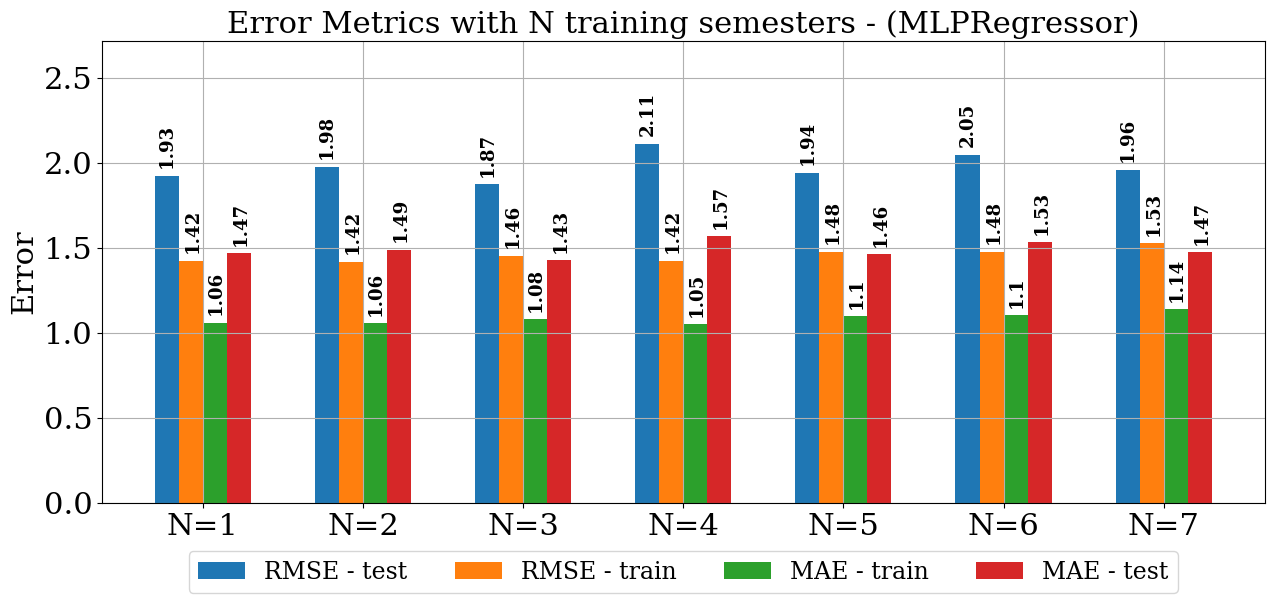

In [18]:
import json
import os
from sklearn.neural_network import MLPRegressor

# Dosya adı
filename = '../results/baseline_regression_results.json'

# 1. ADIM: Mevcut sonuçları dosyadan yükle
if os.path.exists(filename):
    with open(filename, 'r') as f:
        model_results = json.load(f)
else:
    model_results = {} # Dosya yoksa boş başlat

# 2. ADIM: Sadece MLPRegressor'ı çalıştır
print("MLPRegressor çalıştırılıyor...")

# Hiperparametreleri al (Sözlüğe eklediğini varsayıyorum)
hps = tuned_hyperparams['MLPRegressor']

# Modeli eğit ve test et
scores = get_error_score(df, columns, MLPRegressor(
    hidden_layer_sizes=hps['hidden_layer_sizes'],
    activation=hps['activation'],
    solver=hps['solver'],
    random_state=42,
    max_iter=500
))

# Sonucu sözlüğe ekle (Diğerleri zaten model_results içinde duruyor)
model_results['MLPRegressor'] = scores

# Opsiyonel: Grafiğini çiz
plot_error_score(scores, 'MLPRegressor')

# 3. ADIM: Dosyayı 'w' modunda (üzerine yazarak) kaydet
# JSON.dump tüm sözlüğüğü (eskiler + MLP) düzgün formatta yazar.
with open('baseline_regression_mlp_added.json', 'w') as fw:
    json.dump(model_results, fw, indent=4)

print("MLPRegressor sonuçları dosyaya eklendi! ✅")

# subset uzerinde tum modelleri calistirma 

In [21]:
# yeni fonksiyon (get error score masked): subset uzerinde calistirmak icin maskeli dataset kullanimi, (cf in tahmin verebildigi datalar uzerinde calismis oluyoruz )
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso # Hangisini kullanıyorsan
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


def get_error_score_masked_regression(df_encoded, df_raw, columns, model, mask, apply_scaling=False):
    """
    Regresyon modelleri için Common Subset hata hesabı.
    """
    error_scores = {}
    
    # Semester sütun indeksi kontrolü (Genelde 7. sütun)
    sorted_semesters = sorted(set(df_encoded.iloc[:, 7])) 
    
    print(f"Regression ({type(model).__name__}) Subset Evaluation running...")
    
    for sem_idx in range(1, len(sorted_semesters)):
        training_sem = sorted_semesters[:sem_idx]
        test_sem = sorted_semesters[sem_idx]
        
        # --- TRAIN VERİSİ ---
        X_train, y_train = get_train_data(df_encoded, training_sem, columns)
        
        # --- TEST VERİSİ ---
        # 1. Kimlik kontrolü için raw veri
        mask_test_rows = df_encoded.iloc[:, 7] == test_sem
        test_df_raw = df_raw[mask_test_rows].copy()
        
        if len(test_df_raw) == 0: continue
            
        # 2. Model için encoded veri
        X_test = df_encoded.loc[mask_test_rows, columns].copy()
        
        # Sütun eşitleme (Gereksiz sütunları atar)
        if hasattr(X_train, 'columns'):
             X_test = X_test[X_train.columns]
        
        # Gerçek Notlar (Regresyon hedefi)
        # NOT: Eğer y_train 'Label Encoded' (0,1,2..) ise y_test de öyle olmalı.
        # Eğer y_train 'Scale' edilmiş notlar ise (0.0 - 4.0 arası), ona dikkat et.
        # Senin yapında 'Letter Grade' üzerinden le.transform kullanılıyordu:
        y_test_full = le.transform(test_df_raw['Letter Grade'])
        
        # --- SCALING (Opsiyonel ama Regresyon için genelde iyidir) ---
        if apply_scaling:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        # --- MODEL EĞİTİMİ ve TAHMİN ---
        model.fit(X_train, y_train)
        y_pred_full = model.predict(X_test)
        
        # --- MASKELEME (Common Subset Filtresi) ---
        y_true_filtered = []
        y_pred_filtered = []
        
        test_df_raw = test_df_raw.reset_index(drop=True)
        
        for i, row in test_df_raw.iterrows():
            student_id = str(row['Student Number'])
            course_code = row['Course Code']
            
            is_valid = False
            
            # Sadece CF'in cevaplayabildiği soruları al
            if test_sem in mask:
                if student_id in mask[test_sem]:
                    if course_code in mask[test_sem][student_id]:
                        is_valid = True
            
            if is_valid:
                y_true_filtered.append(y_test_full[i])
                y_pred_filtered.append(y_pred_full[i])
        
        # --- METRİK HESABI ---
        if len(y_true_filtered) > 0:
            rmse_test = round(np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered)), 3)
            mae_test = round(mean_absolute_error(y_true_filtered, y_pred_filtered), 3)
        else:
            rmse_test, mae_test = 0, 0
            
        error_scores.setdefault(sem_idx, {})
        error_scores[sem_idx]['rmse'] = [0, rmse_test]
        error_scores[sem_idx]['mae'] = [0, mae_test]
        
        # print(f"Sem {sem_idx}: RMSE {rmse_test}") # İstersen aç

    return error_scores

In [22]:
import json
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import Lasso, Ridge, BayesianRidge
from sklearn.neural_network import MLPRegressor

# 1. Maskeyi Yükle
with open('sota_subset_mask.json', 'r') as f:
    valid_mask = json.load(f)

# 2. Sonuçları Tutacak Sözlük
subset_results = {}

print("Common Subset Değerlendirmesi Başlıyor... Bu işlem biraz sürebilir ⏳")

# --- 1. SVR (Support Vector Regression) ---
if 'SVR' in tuned_hyperparams:
    print("Running SVR (Subset)...")
    hps = tuned_hyperparams['SVR']
    model = SVR(C=hps['C'], kernel=hps['kernel'], epsilon=hps['epsilon'])
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=True # SVR için Scaling ŞART
    )
    subset_results['SVR'] = scores

# --- 2. Bayesian Ridge ---
if 'BayesianRidge' in tuned_hyperparams:
    print("Running BayesianRidge (Subset)...")
    hps = tuned_hyperparams['BayesianRidge']
    model = BayesianRidge(lambda_1=hps['lambda_1'], alpha_1=hps['alpha_1'], 
                          lambda_2=hps['lambda_2'], alpha_2=hps['alpha_2'])
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=True # Lineer modeller için Scaling önerilir
    )
    subset_results['BayesianRidge'] = scores

# --- 3. Lasso ---
if 'Lasso' in tuned_hyperparams:
    print("Running Lasso (Subset)...")
    hps = tuned_hyperparams['Lasso']
    model = Lasso(alpha=hps['alpha'])
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=True
    )
    subset_results['Lasso'] = scores

# --- 4. Ridge ---
if 'Ridge' in tuned_hyperparams:
    print("Running Ridge (Subset)...")
    hps = tuned_hyperparams['Ridge']
    model = Ridge(alpha=hps['alpha'])
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=True
    )
    subset_results['Ridge'] = scores

# --- 5. Bagging Regressor ---
if 'BaggingRegressor' in tuned_hyperparams:
    print("Running Bagging (Subset)...")
    hps = tuned_hyperparams['BaggingRegressor']
    model = BaggingRegressor(n_estimators=hps['n_estimators'], random_state=42)
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=False # Ağaç tabanlıysa False olabilir
    )
    subset_results['BaggingRegressor'] = scores

# --- 6. AdaBoost ---
if 'AdaBoostRegressor' in tuned_hyperparams:
    print("Running AdaBoost (Subset)...")
    hps = tuned_hyperparams['AdaBoostRegressor']
    model = AdaBoostRegressor(n_estimators=hps['n_estimators'], learning_rate=hps['learning_rate'], random_state=42)
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=False
    )
    subset_results['AdaBoostRegressor'] = scores

# --- 7. RandomForest ---
if 'RandomForestRegressor' in tuned_hyperparams:
    print("Running RandomForest (Subset)...")
    hps = tuned_hyperparams['RandomForestRegressor']
    model = RandomForestRegressor(n_estimators=hps['n_estimators'], random_state=42)
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=False
    )
    subset_results['RandomForestRegressor'] = scores

# --- 8. Gradient Boosting ---
if 'GradientBoostingRegressor' in tuned_hyperparams:
    print("Running GradientBoosting (Subset)...")
    hps = tuned_hyperparams['GradientBoostingRegressor']
    model = GradientBoostingRegressor(
        n_estimators=hps['n_estimators'], learning_rate=hps['learning_rate'], 
        max_depth=hps.get('max_depth', 3), loss=hps.get('loss', 'squared_error'), # 'huber' eski versiyonlarda olabilir
        random_state=42
    )
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=False
    )
    subset_results['GradientBoostingRegressor'] = scores

# --- 9. MLP Regressor (Neural Net) ---
if 'MLPRegressor' in tuned_hyperparams:
    print("Running MLPRegressor (Subset)...")
    hps = tuned_hyperparams['MLPRegressor']
    model = MLPRegressor(
        hidden_layer_sizes=hps['hidden_layer_sizes'],
        activation=hps['activation'],
        solver=hps['solver'],
        random_state=42, max_iter=500
    )
    
    scores = get_error_score_masked_regression(
        df_encoded=df, df_raw=df_raw, columns=columns, model=model, mask=valid_mask, 
        apply_scaling=True # NN için Scaling ŞART
    )
    subset_results['MLPRegressor'] = scores


# 3. SONUÇLARI KAYDET
with open('results_baseline_regression_subset.json', 'w') as fw:
    json.dump(subset_results, fw, indent=4)

print("\n✅ TÜM MODELLER TAMAMLANDI!")
print("Sonuçlar 'baseline_regression_subset_results.json' dosyasına kaydedildi.")

Common Subset Değerlendirmesi Başlıyor... Bu işlem biraz sürebilir ⏳
Running SVR (Subset)...
Regression (SVR) Subset Evaluation running...
Running BayesianRidge (Subset)...
Regression (BayesianRidge) Subset Evaluation running...
Running Lasso (Subset)...
Regression (Lasso) Subset Evaluation running...
Running Ridge (Subset)...
Regression (Ridge) Subset Evaluation running...
Running Bagging (Subset)...
Regression (BaggingRegressor) Subset Evaluation running...
Running AdaBoost (Subset)...
Regression (AdaBoostRegressor) Subset Evaluation running...
Running RandomForest (Subset)...
Regression (RandomForestRegressor) Subset Evaluation running...
Running GradientBoosting (Subset)...
Regression (GradientBoostingRegressor) Subset Evaluation running...
Running MLPRegressor (Subset)...
Regression (MLPRegressor) Subset Evaluation running...

✅ TÜM MODELLER TAMAMLANDI!
Sonuçlar 'baseline_regression_subset_results.json' dosyasına kaydedildi.
